In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import heapq
import itertools

In [ ]:
# device

In [2]:
dir = 'data_original/'

classes = os.listdir(dir)
num_classes = len(classes)

print(
    f'Number of classes: {num_classes}',
    f'\nClasses: {classes}'
)

Number of classes: 4 
Classes: ['cloudy', 'rain', 'shine', 'sunrise']


In [3]:
print("--------data--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(dir + cls))}')

--------data--------
cloudy: 299
rain: 210
shine: 253
sunrise: 67


In [4]:
import os
import imghdr
import shutil

def delete_irrelevant_files(directory, classes):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        with os.scandir(class_dir) as entries:
            for entry in entries:
                # Delete directories
                if entry.is_dir():
                    print(f'Deleting directory: {entry.path}')
                    shutil.rmtree(entry.path)

                # Check if the file is empty and delete it
                elif os.path.getsize(entry.path) == 0:
                    print(f'Deleting empty file: {entry.path}')
                    os.remove(entry.path)

                # Check if the file is not an image and delete it
                elif not imghdr.what(entry.path):
                    print(f'Deleting non-image file: {entry.path}')
                    os.remove(entry.path)

print("--------data--------")
delete_irrelevant_files(dir, classes)

--------data--------


In [5]:
images = []
for cls in classes:
    # img = cv2.imread(dir + cls + '/' + os.listdir(original_dir + cls)[0])
    img = Image.open(dir + cls + '/' + os.listdir(dir + cls)[0])
    images.append(img)

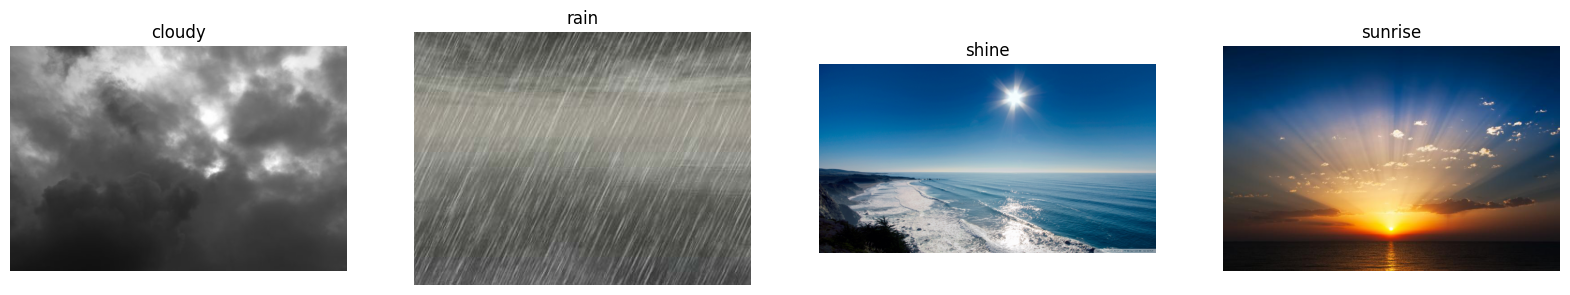

In [6]:
%matplotlib inline

fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(classes[i])
    ax.axis('off')

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, directory, classes, transform=None):
        self.directory = directory
        self.classes = classes
        self.transform = transform
        self.data = []

        for cls in classes:
            class_dir = os.path.join(directory, cls)
            with os.scandir(class_dir) as entries:
                for entry in entries:
                    self.data.append((entry.path, cls))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the WeatherDataset
dataset = WeatherDataset(directory=dir, classes=['cloudy', 'rain', 'shine', 'sunrise'], transform=transform)
print(f'Test dataset size: {len(dataset)}')

Test dataset size: 829


In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
class CNNEncoder(nn.Module):
    def __init__(self, input_channels, hidden_dim):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 7 * 7, hidden_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, hidden_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [11]:
class CNNDecoder(nn.Module):
    def __init__(self, hidden_dim, output_channels):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(hidden_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z

In [12]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, output_channels):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = CNNEncoder(input_channels, hidden_dim)
        self.decoder = CNNDecoder(hidden_dim, output_channels)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [13]:
import torch.optim as optim
import torch.nn.functional as F

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Train dataset size: 663
Test dataset size: 166


In [14]:
def kl_divergence_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def criterion(recon_x, x, mu, logvar):
    kl_loss = kl_divergence_loss(mu, logvar)
    recon_loss = reconstruction_loss(recon_x, x)
    return recon_loss + kl_loss

In [15]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    scaler = GradScaler()  
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        with autocast():
            recon_batch, mu, logvar = model(data)
            loss = criterion(recon_batch, data, mu, logvar)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [16]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            with autocast():
                recon_batch, mu, logvar = model(data)
                test_loss += criterion(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
num_epochs = 10
lr = 1e-3

model = VariationalAutoencoder(input_channels=1, hidden_dim=20, output_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

NameError: name 'num_epochs' is not defined